In [1]:
import yasp

In [2]:
import numpy as np
import array

import heppyy.util.fastjet_cppyy
import heppyy.util.heppyy_cppyy

from cppyy.gbl import fastjet as fj
from cppyy.gbl.std import vector

import ROOT

/Users/ploskon/devel/yasp/software/root/6.28.00/lib/cppyy_backend/loader.py:90: UserWarning: No precompiled header available (/Users/ploskon/devel/yasp/software/root/6.28.00/lib/cppyy_backend/etc not writable); this may impact performance.
  warnings.warn('No precompiled header available (%s); this may impact performance.' % msg)
[i] Creating YaspCppyyHelper singleton.


[i] cppyyhelper (4405887696)
   loaded_packages = ['fastjet']
   loaded_libs = ['fastjet', 'LundPlane', 'EnergyCorrelator']
   paths_include = ['/Users/ploskon/devel/yasp/software/fastjet/3.4.0/include']
   paths_lib = ['/Users/ploskon/devel/yasp/software/fastjet/3.4.0/lib']
[i] cppyyhelper (4405887696)
   loaded_packages = ['fastjet', 'heppyy']
   loaded_libs = ['fastjet', 'LundPlane', 'EnergyCorrelator', 'heppyy_eec', 'heppyy_fjutil']
   paths_include = ['/Users/ploskon/devel/yasp/software/fastjet/3.4.0/include', '/Users/ploskon/devel/yasp/software/heppyy/current/include']
   paths_lib = ['/Users/ploskon/devel/yasp/software/fastjet/3.4.0/lib', '/Users/ploskon/devel/yasp/software/heppyy/current/lib']
Welcome to JupyROOT 6.28/04


In [3]:
pythia_config = [
    'HardQCD:all = on',
    'Next:numberCount = 0',
    'Next:numberShowEvent = 0',
    'Next:numberShowInfo = 0',
    'Next:numberShowProcess = 0',
    'PhaseSpace:pTHatMin = 100.00000'
]

stable_charm = False
if stable_charm:
	for c in [411,413,421,423,431,433]:
		pythia_config.append(f'{c}:mayDecay=false')
		pythia_config.append(f'-{c}:mayDecay=false')

stable_beauty = False
if stable_beauty:
	for c in [511,513,521,523,531,533]:
		pythia_config.append(f'{c}:mayDecay=false')
		pythia_config.append(f'-{c}:mayDecay=false')


In [4]:
import heppyy.util.pythia8_cppyy
from cppyy.gbl import Pythia8

[i] cppyyhelper (4405887696)
   loaded_packages = ['fastjet', 'heppyy', 'pythia8']
   loaded_libs = ['fastjet', 'LundPlane', 'EnergyCorrelator', 'heppyy_eec', 'heppyy_fjutil', 'pythia8']
   paths_include = ['/Users/ploskon/devel/yasp/software/fastjet/3.4.0/include', '/Users/ploskon/devel/yasp/software/heppyy/current/include', '/Users/ploskon/devel/yasp/software/pythia8/8308/include']
   paths_lib = ['/Users/ploskon/devel/yasp/software/fastjet/3.4.0/lib', '/Users/ploskon/devel/yasp/software/heppyy/current/lib', '/Users/ploskon/devel/yasp/software/pythia8/8308/lib']


In [5]:
pythia = Pythia8.Pythia()
_ = [pythia.readString(s) for s in pythia_config]


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.308      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Nov 2022  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |   P       Y      T    H   H  III  A   A    Now is 14 Nov 2023 at 00:29:22    |  | 
 |  |                                                                              |  | 
 |  |   Program docu

In [6]:
pythia.init()

True


 *-------  PYTHIA Process Initialization  --------------------------*
 |                                                                  |
 | We collide p+ with p+ at a CM energy of 1.400e+04 GeV            |
 |                                                                  |
 |------------------------------------------------------------------|
 |                                                    |             |
 | Subprocess                                    Code |   Estimated |
 |                                                    |    max (mb) |
 |                                                    |             |
 |------------------------------------------------------------------|
 |                                                    |             |
 | g g -> g g                                     111 |   5.045e-03 |
 | g g -> q qbar (uds)                            112 |   6.877e-05 |
 | q g -> q g                                     113 |   5.922e-03 |
 | q q(bar)' -> q q

In [7]:
jet_R0 = 0.4
jet_etamax = 2.
jet_ptmin = 100.
jet_ptmax = 120.

hadron_etamax = jet_etamax + jet_R0 * 1.05

jet_def = fj.JetDefinition(fj.antikt_algorithm, jet_R0)
jet_selector = fj.SelectorPtMin(jet_ptmin) * fj.SelectorPtMax(jet_ptmax) * fj.SelectorAbsEtaMax(hadron_etamax - jet_R0 * 1.05)
jet_def_lund = fj.JetDefinition(fj.cambridge_algorithm, 1.0)

h = ROOT.TH1F("rho", "rho;R;1/N_{jets} dN_{particles}/dR", 10, 0, jet_R0) 

In [8]:
nevents = 10000
njets = 0
from tqdm.notebook import tqdm
for i in tqdm(range(nevents)):
    if not pythia.next():
        continue
    # parts = vector[fj.PseudoJet]([fj.PseudoJet(p.px(), p.py(), p.pz(), p.e()) for p in pythia.event if p.isFinal() and p.isCharged()])
    parts = vector[fj.PseudoJet]([fj.PseudoJet(p.px(), p.py(), p.pz(), p.e()) for p in pythia.event if p.isFinal()])
    jets = fj.sorted_by_pt(jet_selector(jet_def(parts)))
    for j in jets:
        for c in j.constituents():
            h.Fill(j.delta_R(c))
    njets += len(jets)

if njets > 0:
    h.Scale(1./njets)

  0%|          | 0/10000 [00:00<?, ?it/s]

#--------------------------------------------------------------------------
#                         FastJet release 3.4.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code
# and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
 PYTHIA Error in StringFragmentation::fragment: stuck in joining  
 PYTHIA Er

In [9]:
%jsroot on

In [10]:
c = ROOT.TCanvas("rho","rho",800,600)
h.Draw()

In [11]:
c.Draw()

In [12]:
pythia.stat()


 *-------  PYTHIA Event and Cross Section Statistics  -------------------------------------------------------------*
 |                                                                                                                 |
 | Subprocess                                    Code |            Number of events       |      sigma +- delta    |
 |                                                    |       Tried   Selected   Accepted |     (estimated) (mb)   |
 |                                                    |                                   |                        |
 |-----------------------------------------------------------------------------------------------------------------|
 |                                                    |                                   |                        |
 | g g -> g g                                     111 |       33893       4749       4749 |   7.215e-04  5.240e-06 |
 | g g -> q qbar (uds)                            112 |        

In [13]:
%jsroot off

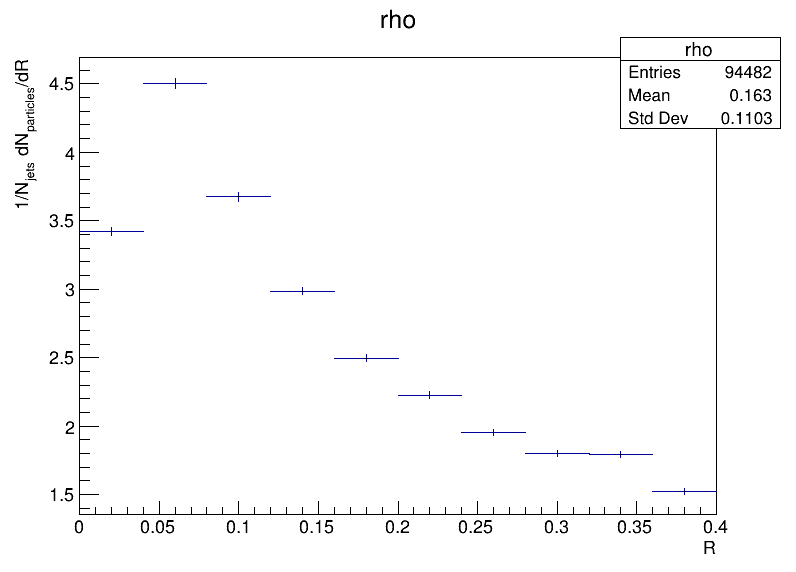

In [14]:
c.Draw()